# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset,random_split
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from dataset import SiameseNetworkDataset,generate_csv
from utils import imshow, show_plot
import config
# generate_csv(config.training_dir)

## Using Image Folder Dataset

In [2]:
siamese_dataset = SiameseNetworkDataset(training_dir=config.training_dir,
                                        training_csv=config.training_csv,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

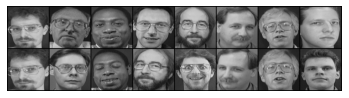

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [3]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [5]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [6]:
# Split the dataset into train, validation and test sets
num_train = round(0.8*siamese_dataset.__len__())
num_validate = round(0.1*siamese_dataset.__len__())
num_test = siamese_dataset.__len__()-num_train-num_validate
siamese_train, siamese_valid, siamese_test = random_split(siamese_dataset, [num_train,num_validate,num_test])
train_dataloader = DataLoader(siamese_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=config.train_batch_size)

In [7]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [8]:
counter = []
loss_history = [] 
iteration_number= 0

In [9]:
for epoch in range(0,config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Epoch number 0
 Current loss 1.3637374619138427

Epoch number 0
 Current loss 1.1375815707578796

Epoch number 0
 Current loss 1.3519059192214629

Epoch number 0
 Current loss 1.542754281219095

Epoch number 0
 Current loss 0.4352005039982032

Epoch number 0
 Current loss 0.5877697105141124

Epoch number 0
 Current loss 0.2822483586292947

Epoch number 0
 Current loss 0.33600457651274546

Epoch number 1
 Current loss 1.574655866622925

Epoch number 1
 Current loss 0.840573700144887

Epoch number 1
 Current loss 0.34127246267162265

Epoch number 1
 Current loss 0.27526004279352495

Epoch number 1
 Current loss 0.2503495085053146

Epoch number 1
 Current loss 0.16418575402349234

Epoch number 1
 Current loss 0.13283383697271348

Epoch number 1
 Current loss 0.21340035540716987

Epoch number 2
 Current loss 0.09635780649259687

Epoch number 2
 Current loss 0.11810711001162418

Epoch number 2
 Current loss 0.06356660259043566

Epoch number 2
 Current loss 0.11069253797177225

Epoch number 

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

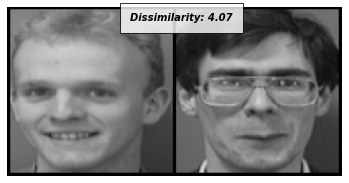

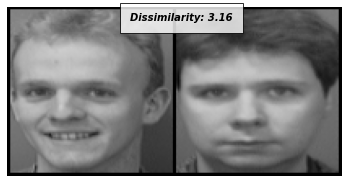

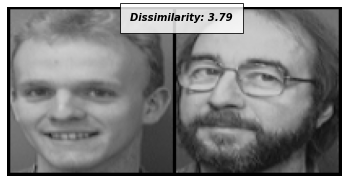

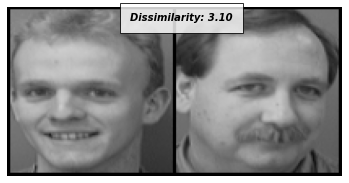

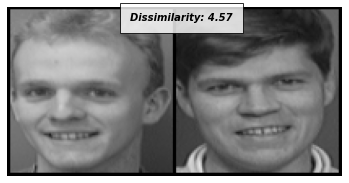

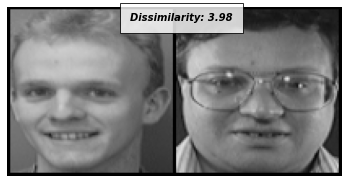

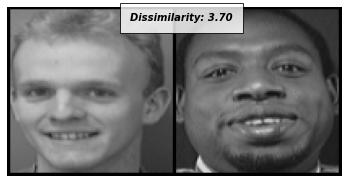

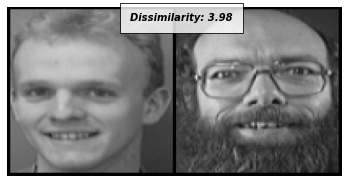

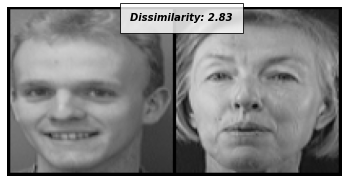

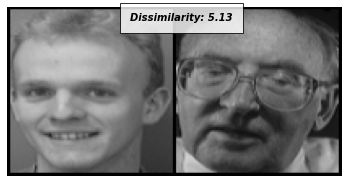

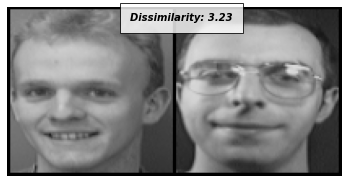

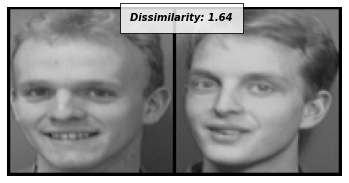

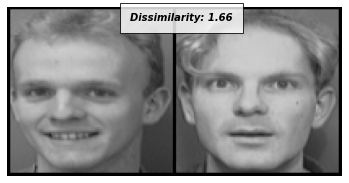

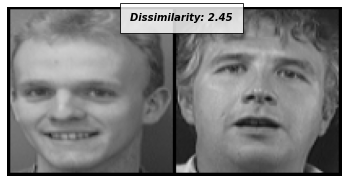

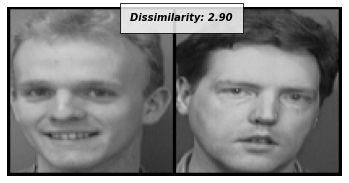

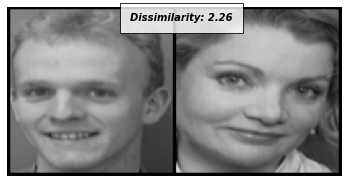

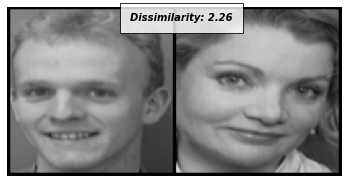

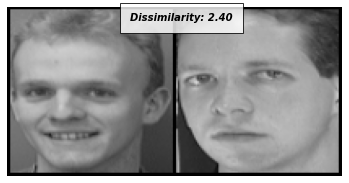

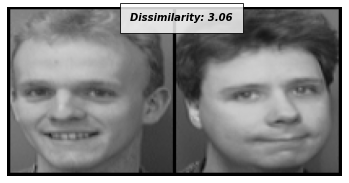

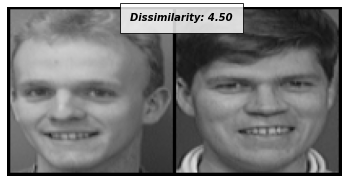

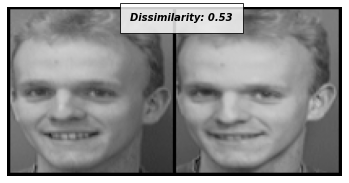

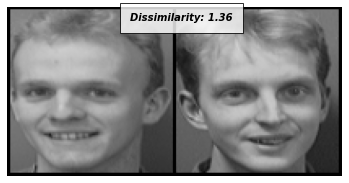

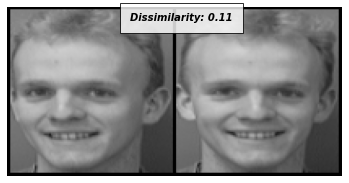

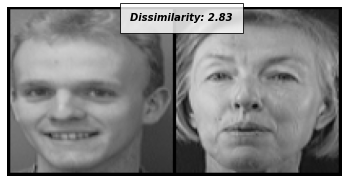

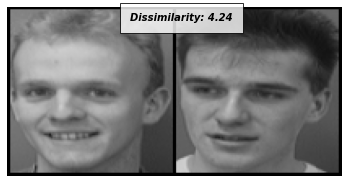

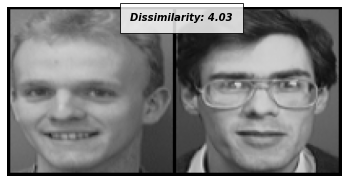

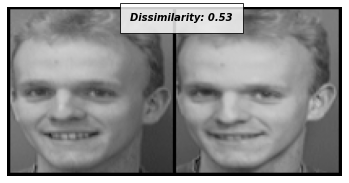

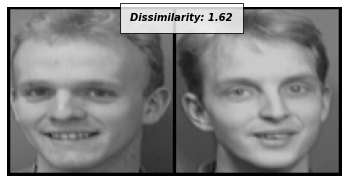

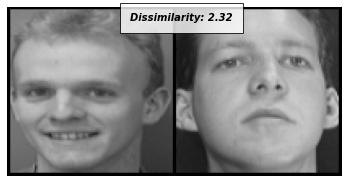

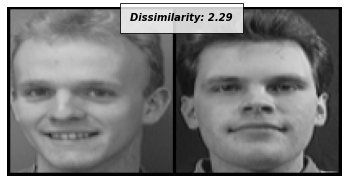

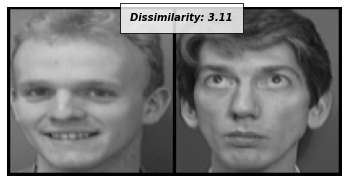

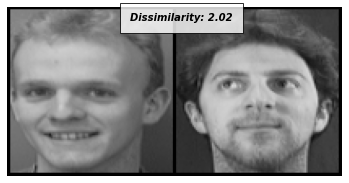

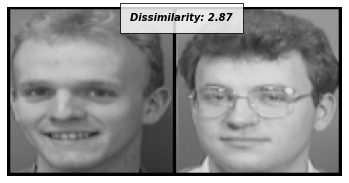

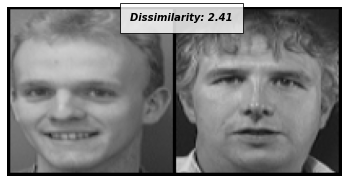

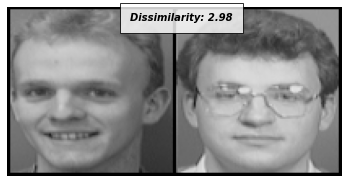

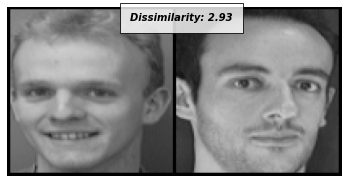

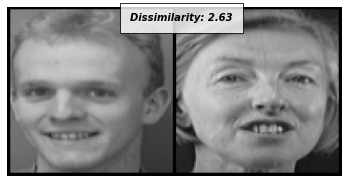

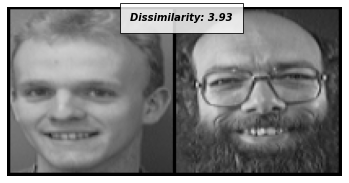

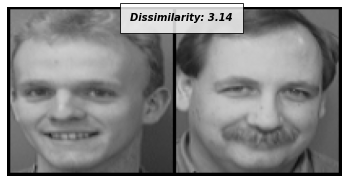

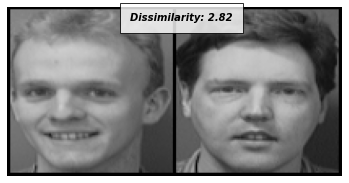

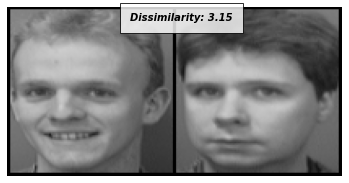

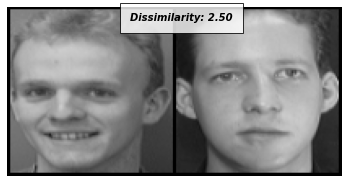

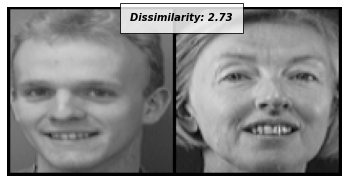

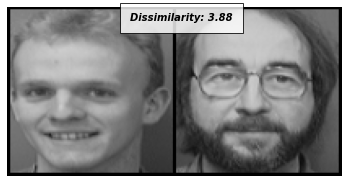

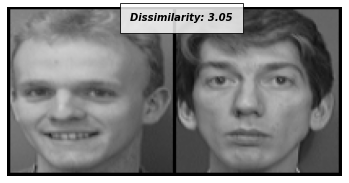

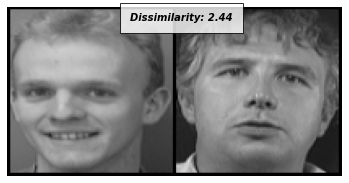

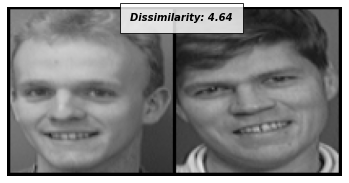

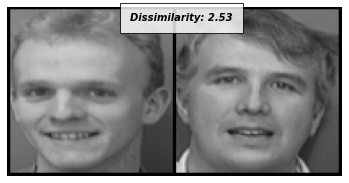

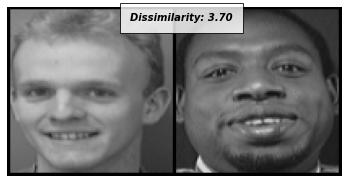

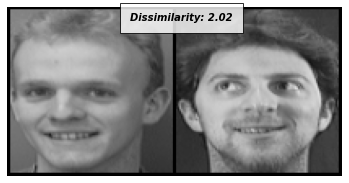

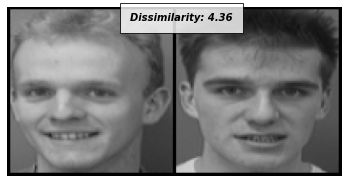

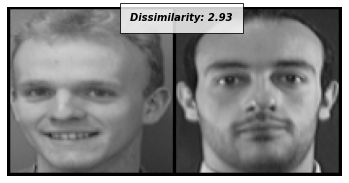

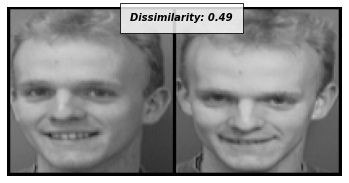

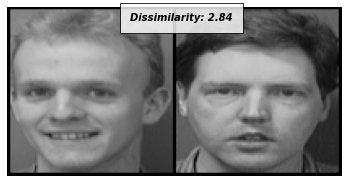

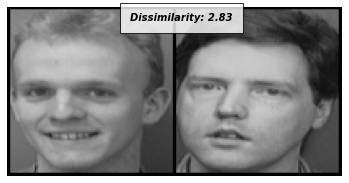

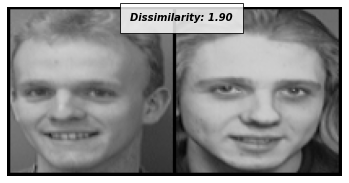

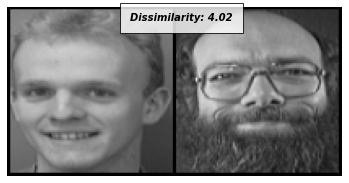

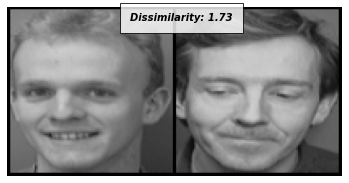

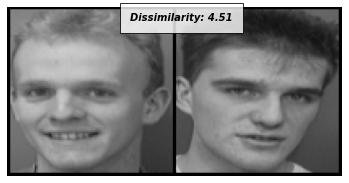

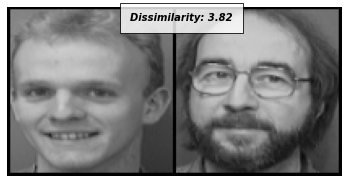

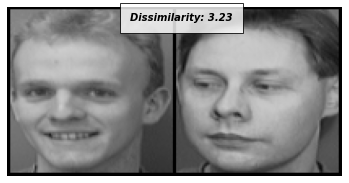

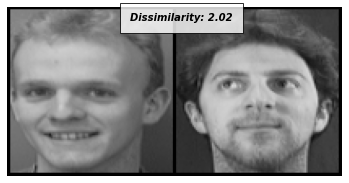

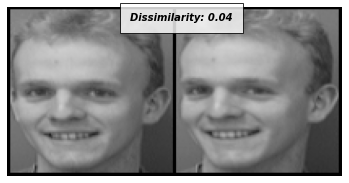

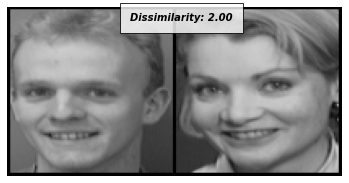

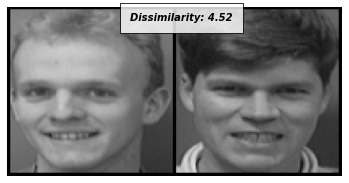

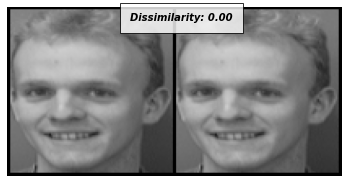

In [10]:
# folder_dataset_test = dset.ImageFolder(root=config.testing_dir)
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transforms.Compose([transforms.Resize((100,100)),
#                                                                       transforms.ToTensor()
#                                                                       ])
#                                        ,should_invert=False)

test_dataloader = DataLoader(siamese_test,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(100):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

